<a href="https://colab.research.google.com/github/YaninaK/sales-forecast/blob/main/notebooks/02_Feature_extraction_fourier_tsfresh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sales forecast for 20 stores for for 31 days' period. 
## Feature extraction with Fourier transform and tsfresh

[EDA - omissions and cluster analysis](
https://colab.research.google.com/drive/1udCgyEt7lusSY43lnduVDEnZvdvVEt9h?usp=sharing)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!git clone -q https://github.com/YaninaK/sales-forecast.git
!pip install -r sales-forecast/requirements_Colab.txt -q 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.2/358.2 KB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 KB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.2/136.2 KB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 48.5 MB/s eta 0:00:00


In [3]:
%cd sales-forecast

/content/sales-forecast


In [4]:
import sys
import os

sys.path.append(os.getcwd())
sys.path.append(os.path.join(os.getcwd(), "src", "sales_forecast"))

In [5]:
import random
import pandas as pd
import numpy as np
import joblib
from sklearn.preprocessing import StandardScaler

from data.make_dataset import load_data, get_dataset
from data.impute_data import impute
from data.validation import train_validation_split
from data.johnson_su_transformation import JohnsonSU
from data.clean_data import clean_outliers
from features.time_series_clusters import get_clusters
from features.features_tsfresh import get_tsfresh_features
from features.features_fourier import get_fourier_features
from features.build_dataset import get_features

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ERROR:numba.cuda.cudadrv.driver:Call to cuInit results in CUDA_ERROR_NO_DEVICE


In [6]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
PATH = '/content/drive/MyDrive/ML_projects/01_Time_series/sales_forecast/'
DEFAULT_RANDOM_SEED = 3

In [8]:
def set_all_seeds(seed=DEFAULT_RANDOM_SEED):
  random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  np.random.seed(seed)

set_all_seeds()

## 1. Data ingestion

In [9]:
data = load_data(PATH)

print(f'data.shape = {data.shape}\n')
data.head(2)

data.shape = (8230, 3)



,id,dt,target
0,0,2016-01-02,747.8
1,0,2016-01-03,681.2


In [10]:
data = get_dataset(data)
data = impute(data)

print(f'data.shape = {data.shape}\n')
data.head(2)

data.shape = (468, 20)



,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
dt,,,,,,,,,,,,,,,,,,,,
2016-01-02,747.8,421.8,546.2,355.7,341.2,341.8,510.9,620.0,1603.4,726.9,656.7,477.2,656.5,697.0,518.4,728.1,343.8,328.5,617.2,370.3
2016-01-03,681.2,427.1,549.3,418.1,326.0,367.5,548.3,605.3,1608.6,677.0,674.4,446.7,685.1,711.2,528.4,758.0,361.6,331.1,523.4,382.3


## 2. Train test split

* 1st half of 2016 and 1st half of 2017

In [11]:
train_df, valid_df, train_df_past, valid_df_past = train_validation_split(data)
train_df.shape, valid_df.shape, train_df_past.shape, valid_df_past.shape

((127, 20), (27, 20), (154, 20), (27, 20))

## 3. Data transformations

### 3.1 Johnson SU transformation

In [12]:
scaler = JohnsonSU()
scaler.fit(train_df.astype(float))

train_df = scaler.transform(train_df.astype(float))
valid_df = scaler.transform(valid_df.astype(float))

X_scaled = pd.concat([train_df, valid_df], axis=0)

In [13]:
scaler_past = JohnsonSU()
scaler_past.fit(train_df_past.astype(float))

X_past_scaled = scaler_past.transform(train_df_past)

### 3.2 Clean outliers

In [14]:
X_scaled = clean_outliers(X_scaled)

Number of outliers = 8


## 4. Get clusters

In [15]:
clusters = get_clusters(X_scaled)

print(f'clusters.shape = {clusters.shape}\n')
clusters.sample(5)

clusters.shape = (20, 5)



,0,1,2,3,4
14,0,1,0,0,0
2,0,0,0,0,1
1,0,1,0,0,0
17,0,0,0,0,1
4,1,0,0,0,0


## 5. Extract features with Fourier transform

In [16]:
fourier_features = get_fourier_features(clusters, X_scaled)
fourier_features.shape

(154, 20, 6)

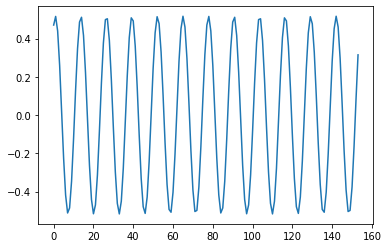

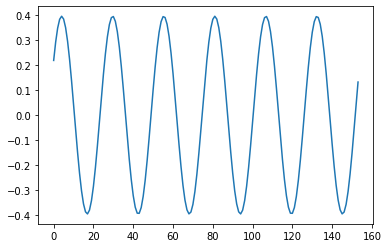

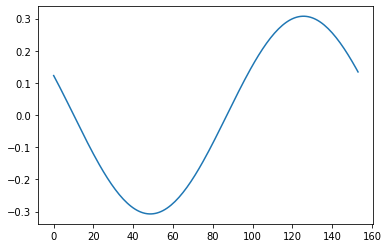

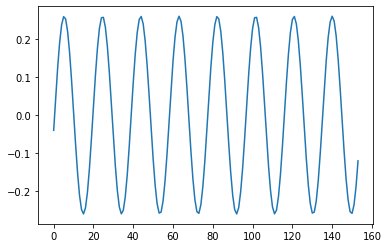

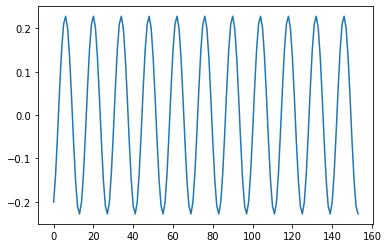

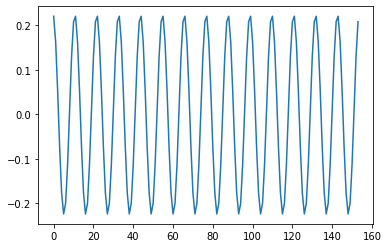

In [17]:
shop = 8
for i in range(fourier_features.shape[2]):
  plt.plot(fourier_features[:, shop, i])
  plt.show();

## 6. Extract features with tsfresh

In [18]:
extracted_features = get_tsfresh_features(X_scaled)
extracted_features.shape

Feature Extraction: 100%|██████████| 20/20 [00:02<00:00,  7.14it/s]


(20, 642)

In [19]:
extracted_features = pd.concat([clusters, extracted_features], axis=1)
extracted_features.shape

(20, 647)

In [20]:
sd_scaler = StandardScaler()
extracted_features_scaled = sd_scaler.fit_transform(extracted_features)

## 7. Build train dataset

In [21]:
X = get_features(
        X_scaled, X_past_scaled, fourier_features, extracted_features_scaled
)
X.shape

(154, 20, 655)